<a href="https://colab.research.google.com/github/O00O297/CCA-AI/blob/master/Data_Traning_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = "/content/drive/Shared drives/Thumbnail/Annotation/input/train/"
path_test = "/content/drive/Shared drives/Thumbnail/Annotation/input/test/"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Get and resize train images and masks
def get_data(path, train=True):

    newpath = path + "images"
    print (newpath)
    ids = next(os.walk(newpath))[2]
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 3), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        #X[n, ..., 0] = x_img.squeeze() / 255
        X[n] = x_img
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

/content/drive/Shared drives/Thumbnail/Annotation/input/train/images
Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)
print(X_train.shape)
print(X_valid.shape)


(979, 128, 128, 3)
(173, 128, 128, 3)


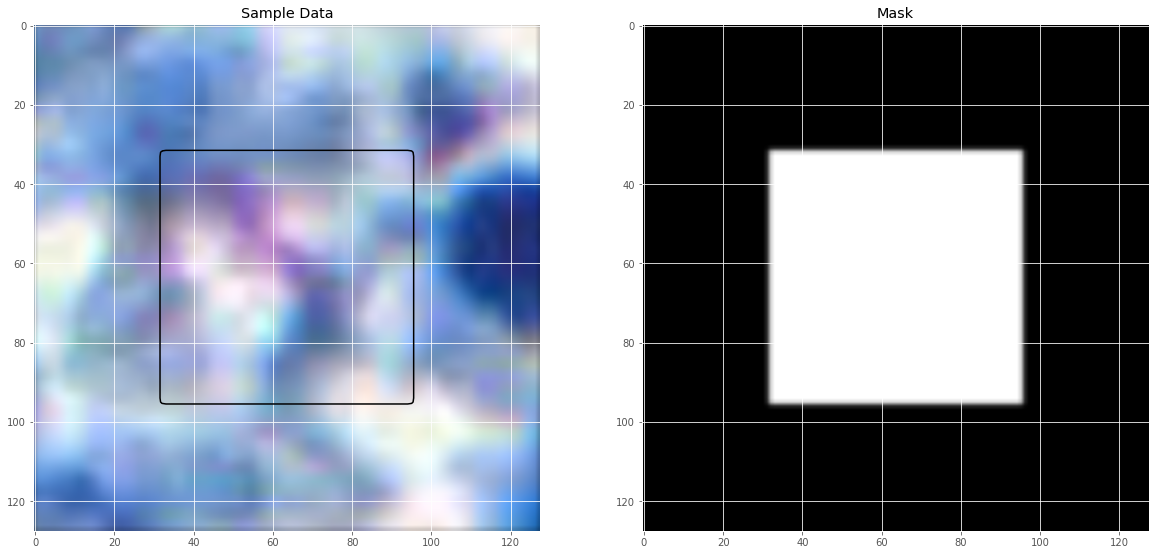

In [ ]:
# Check if training data looks all right
ix = 2
#print(X_train[ix])

has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix].astype(np.uint8).squeeze(), interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Sample Data')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [ ]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/Shared drives/Thumbnail/Model/model-tgs-salt3D2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))


Train on 979 samples, validate on 173 samples
Epoch 1/30
979/979 [==============================] - 208s 213ms/step - loss: 0.3327 - accuracy: 0.8969 - val_loss: 53.1644 - val_accuracy: 0.1356

Epoch 00001: val_loss improved from inf to 53.16437, saving model to /content/drive/Shared drives/Thumbnail/Model/model-tgs-salt3D2.h5
Epoch 2/30
979/979 [==============================] - 202s 206ms/step - loss: 0.1470 - accuracy: 0.9677 - val_loss: 14.4820 - val_accuracy: 0.6246

Epoch 00002: val_loss improved from 53.16437 to 14.48199, saving model to /content/drive/Shared drives/Thumbnail/Model/model-tgs-salt3D2.h5
Epoch 3/30
979/979 [==============================] - 205s 210ms/step - loss: 0.1116 - accuracy: 0.9722 - val_loss: 1.7024 - val_accuracy: 0.7363

Epoch 00003: val_loss improved from 14.48199 to 1.70240, saving model to /content/drive/Shared drives/Thumbnail/Model/model-tgs-salt3D2.h5
Epoch 4/30
979/979 [==============================] - 205s 209ms/step - loss: 0.0921 - accuracy: 

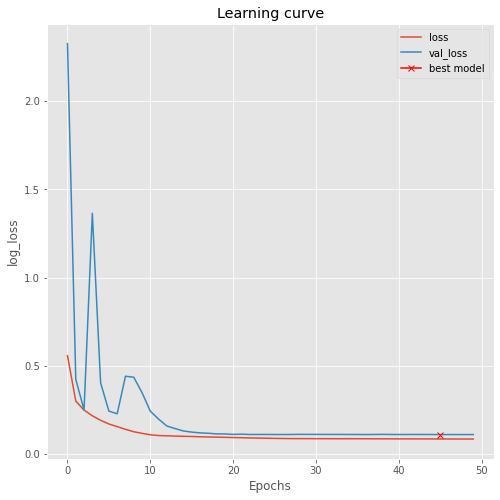

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [ ]:
# Load best model
model.load_weights('/content/drive/Shared drives/Thumbnail/Model/model-tgs-salt3D2.h5')


In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


173/173 [==============================] - 10s 55ms/step


[0.03511421419034114, 0.9786577820777893]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

#print (preds_train[0])

In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix].astype(np.uint8))
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    # ax[1].imshow(y[ix].squeeze())
    # ax[1].set_title('Salt')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=2)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Predicted')
    
    ax[2].imshow(X[ix].astype(np.uint8).squeeze())
    if has_mask:
        ax[2].contour(binary_preds[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Detection Result');


In [ ]:
print(preds_val_t.shape)
TP = 0
TN = 0
FP = 0
FN = 0
for im,y in zip(preds_val_t,y_valid):
  b = sum(sum(im))
  a = sum(sum(y))
  if(a != 0 and b != 0):  TP = TP+1
  if(a != 0 and b == 0) : FN = FN+1
  if(a == 0 and b == 0) : TN = TN+1
  if(a ==0  and b != 0) : FP = FP+1 
  
print(TP)
print(TN)
print(FP)
print(FN)

   
  

(173, 128, 128, 1)
84
76
0
13


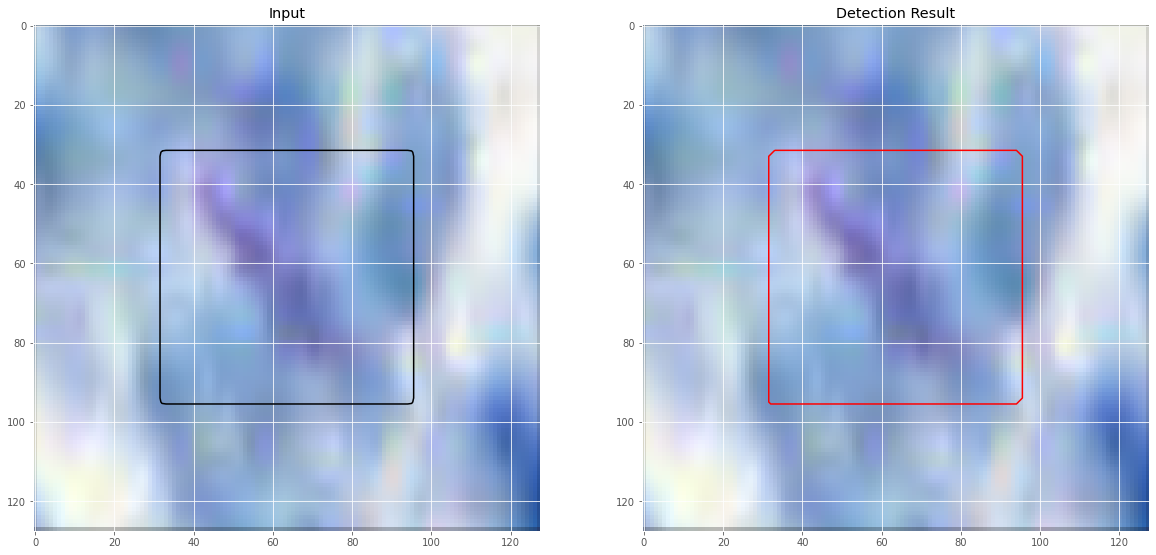

In [ ]:
# Check if training data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=5)


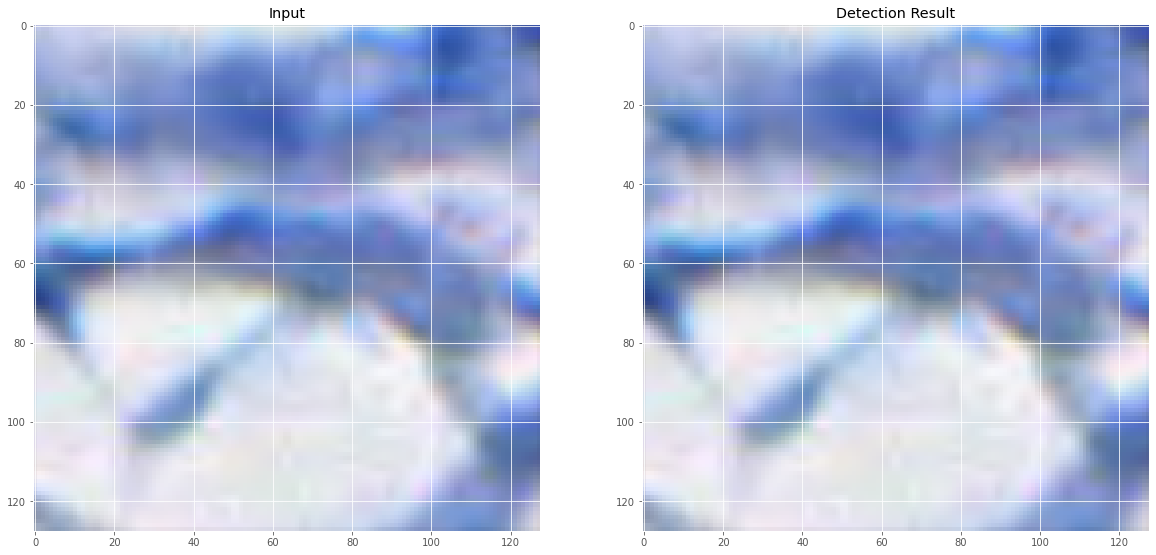

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=3)

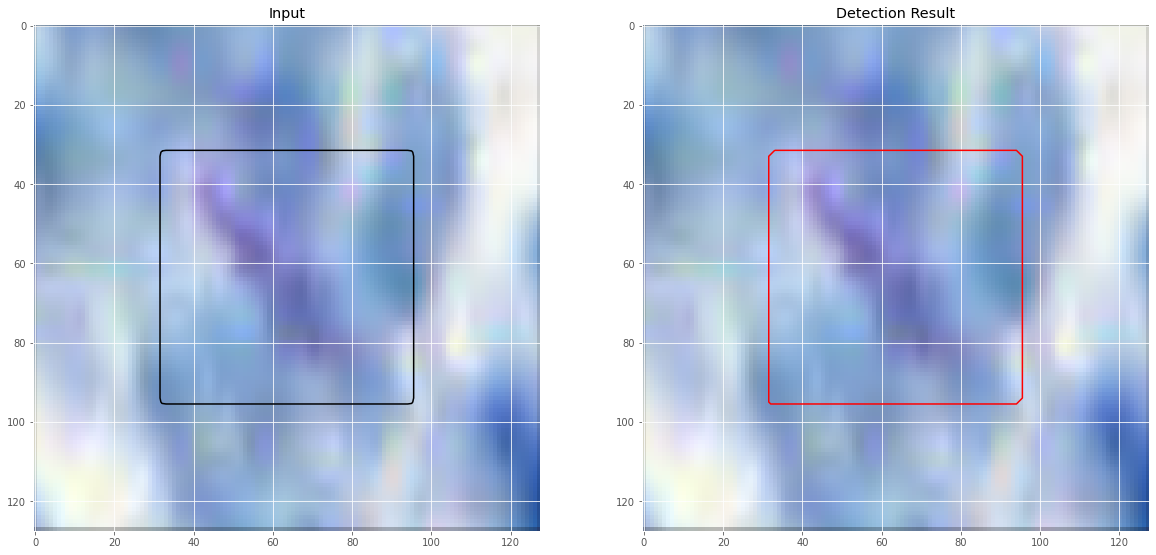

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=5)

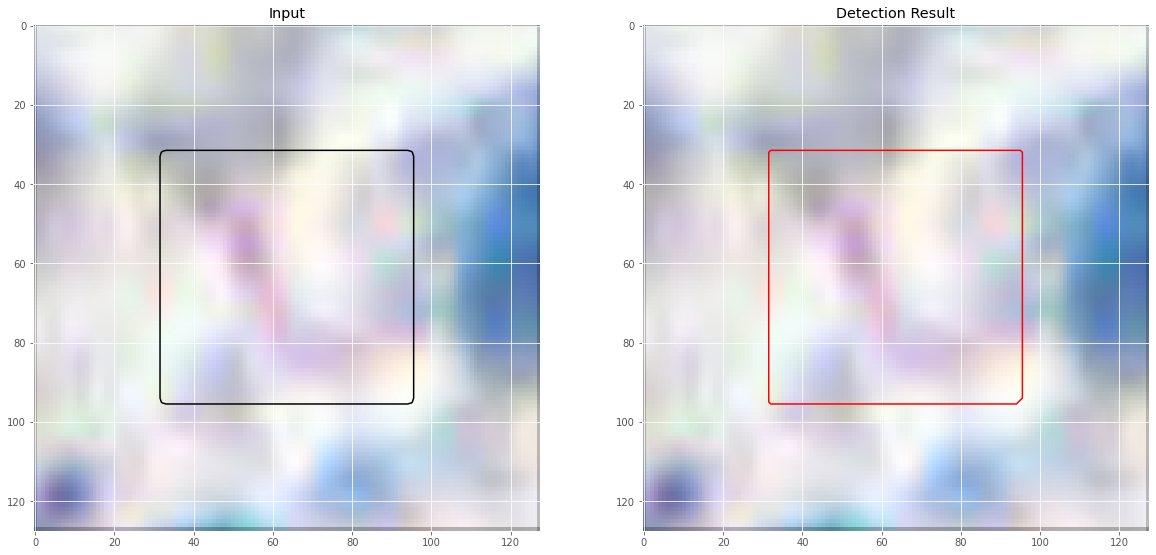

In [ ]:
# Check if valid data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=200)


/content/drive/Shared drives/Thumbnail/Annotation/input/train/test/images
Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



Done!


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


2/2 [==============================] - 0s 72ms/step


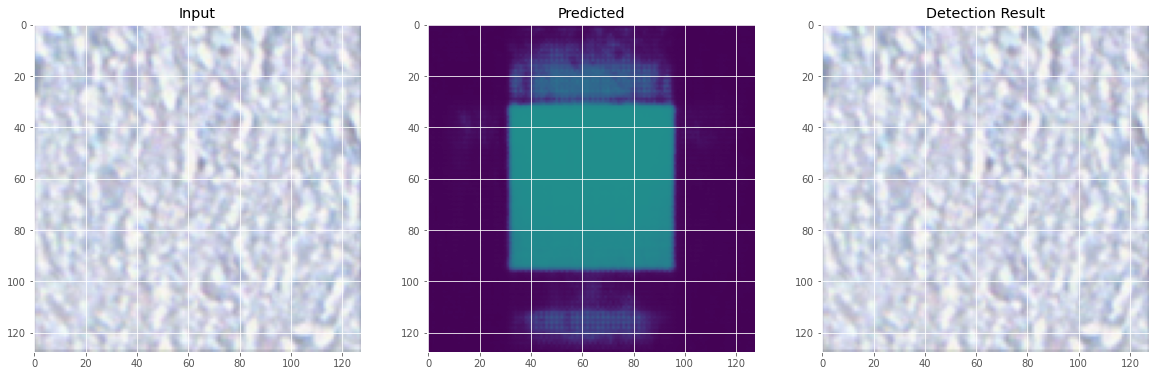

In [ ]:
#Test

tt = "/content/drive/Shared drives/Thumbnail/Annotation/input/train/test/"



X_test, y_test = get_data(tt, train=True)
preds_test = model.predict(X_test, verbose=1)

# print (preds_test)
ix = 1
# print (preds_test[0].shape)
# imgs = preds_test[ix] * 255
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# # print (preds_test[0])
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# # ax[0].imshow(X_test[4, ..., 0], cmap='seismic')
# ax[0].imshow(imgs.squeeze(), cmap='seismic')

# f, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(preds_test_t[ix].squeeze(), vmin=0, vmax=1)
# ax[1].imshow(X_test[ix, ..., 0], cmap='seismic')

plot_sample(X_test, y_test, preds_test, preds_test_t, ix=1)

In [ ]:
tt = "/content/drive/Shared drives/Thumbnail/Annotation/input/train/"

def get_data2(path, train=True):

    newpath = path + "test"
    print (newpath)
    ids = next(os.walk(newpath))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(newpath + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(newpath + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X2, y2 = get_data2(tt, train=True)
p2 = model.predict(X2, verbose=1)

print (X2, y2)

# f, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(X2)
# ax[1].imshow(y2)

# # Threshold predictions
# preds_2 = (p2 > 0.5).astype(np.uint8)
# plot_sample2(X2, y2, p2, preds_2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import cv2
from google.colab.patches import cv2_imshow
# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet','white'])
#ihc_rgb = data.immunohistochemistry()
#ihc_rgb0 = io.imread('/content/drive/My Drive/histoimage/im84.tif')
ihc_tgb = cv2.imread('/content/drive/Shared drives/Thumbnail/Annotation/input/train/images/Positive_2_71_197.tiff')
#ihc_rgb = ihc_rgb0[:,:,0:3] 

# cv2_imshow(ihc_tgb)
ihc_tgb = cv2.cvtColor(ihc_tgb, cv2.COLOR_RGB2BGR)

ihc_hed = rgb2hed(ihc_tgb)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()


ax[0].imshow(oo)
ax[0].set_title("Original image")
ax[1].imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")
ax[2].imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")
ax[3].imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

error: ignored